# SDoH Extraction using LLMs

## 0. Setup

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd
import os
from pathlib import Path
import sys
from IPython.display import display, HTML

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

In [9]:
# Define SDOH categories
EXPECTED_SDOH = [
        'EmploymentStatus', 'Housing', 'Transportation', 'ParentalStatus',
        'RelationshipStatus', 'SocialSupport', 'SubstanceUse', 
        'FinancialSituation', 'EducationLevel', 'FoodInsecurity',
        'NoSDOH'
    ]

GUEVARA_SDOH = [
    'EMPLOYMENT', 'HOUSING', 'PARENT', 'RELATIONSHIP',
    'SUPPORT', 'TRANSPORTATION'
]

# Load cleaned data
brc_referrals_cleaned = pd.read_csv("../data/processed/BRC_referrals_cleaned.csv")

## 1. Exploratory Data Analysis

Proportion of referrals with less than 5 words: 46.28%
Proportion of referrals with less than 10 words: 66.06%


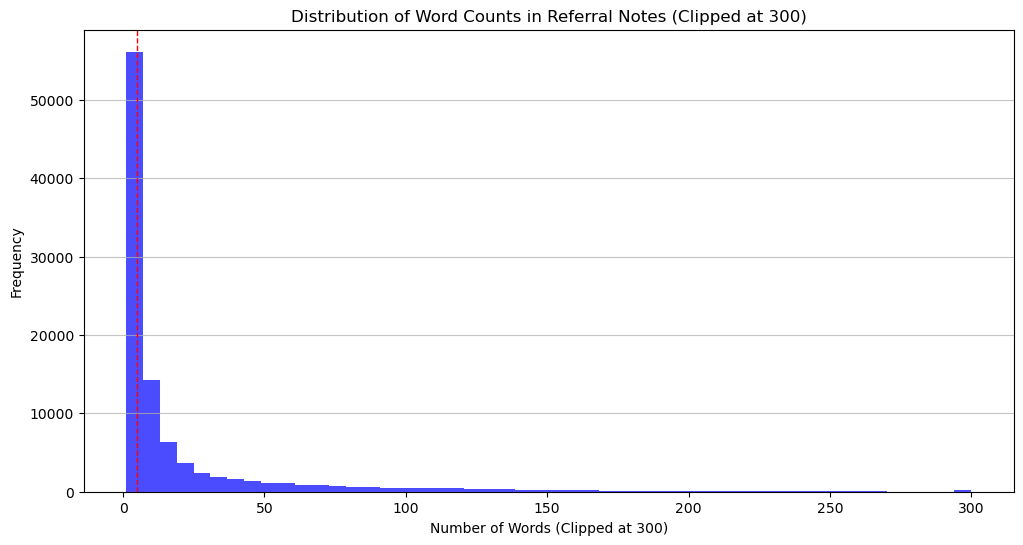

Median number of sentences in referral notes: 2.0


In [10]:
proportion_v_short_referrals = (brc_referrals_cleaned['Referral Notes (depersonalised)'].str.split().str.len() < 5).mean()
print(f"Proportion of referrals with less than 5 words: {proportion_v_short_referrals:.2%}")

proportion_short_referrals = (brc_referrals_cleaned['Referral Notes (depersonalised)'].str.split().str.len() < 10).mean()
print(f"Proportion of referrals with less than 10 words: {proportion_short_referrals:.2%}")

# Visualise the number of words in referral notes
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
brc_referrals_cleaned['word_count'] = brc_referrals_cleaned['Referral Notes (depersonalised)'].str.split().str.len()
plt.hist(brc_referrals_cleaned['word_count'].clip(upper=300), bins=50, color='blue', alpha=0.7)
# Add median line
median_word_count = brc_referrals_cleaned['word_count'].median()
plt.axvline(median_word_count, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_word_count}')
plt.title('Distribution of Word Counts in Referral Notes (Clipped at 300)')
plt.xlabel('Number of Words (Clipped at 300)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(f"Median number of sentences in referral notes: {brc_referrals_cleaned['Referral Notes (depersonalised)'].str.split('.').str.len().median()}")

## 2. Few-shot classification of SDoH

### 2.1 Loading the models

In [11]:
import torch
import transformers

# Use shared cache
os.environ['HF_HOME'] = '/data/resource/huggingface'
os.environ['TRANSFORMERS_OFFLINE'] = '1'  # Force offline mode

# What models are available
cache_dir = "/data/resource/huggingface/hub"
available_models = []

if os.path.exists(cache_dir):
    for item in os.listdir(cache_dir):
        if item.startswith("models--"):
            # Convert models--org--name to org/name format
            model_name = item.replace("models--", "").replace("--", "/")
            available_models.append(model_name)

print("Available cached models:")
for model in sorted(available_models):
    print(f"  {model}")

Available cached models:
  CohereForAI/aya-23-35B
  CohereForAI/aya-23-8B
  CohereForAI/aya-vision-8b
  HuggingFaceTB/SmolLM-135M-Instruct
  LLaMAX/LLaMAX3-8B-Alpaca
  Qwen/Qwen2.5-1.5B
  Qwen/Qwen2.5-3B
  Qwen/Qwen2.5-72B-Instruct
  Qwen/Qwen2.5-7B
  Qwen/Qwen2.5-7B-Instruct
  Qwen/Qwen2.5-7B-instruct
  Qwen/Qwen2.5-VL-7B-Instruct
  Qwen/Qwen3-0.6B
  Qwen/Qwen3-8B
  Unbabel/wmt20-comet-qe-da
  Unbabel/wmt22-comet-da
  bert-base-uncased
  bert-large-uncased
  cardiffnlp/twitter-roberta-base-sentiment
  clairebarale/refugee_cases_ner
  deepseek-ai/DeepSeek-R1-Distill-Llama-70B
  deepseek-ai/DeepSeek-R1-Distill-Llama-8B
  deepseek-ai/DeepSeek-R1-Distill-Qwen-14B
  deepseek-ai/DeepSeek-R1-Distill-Qwen-32B
  deepseek-ai/DeepSeek-R1-Distill-Qwen-7B
  facebook/nllb-200-3.3B
  facebook/nllb-200-distilled-1.3B
  facebook/nllb-200-distilled-600M
  google/gemma-3-1b-it
  google/gemma-3-27b-it
  google/gemma-3-27b-it-qat-q4_0-gguf
  gpt2
  gpt2-medium
  gpt2-xl
  hfl/chinese-bert-wwm
  hfl/chines

In [12]:
print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Transformers version: 4.52.3
PyTorch version: 2.6.0
CUDA available: True


In [14]:
# Load one of the instruction-tuned models
# Qwen/Qwen2.5-7B-Instruct
# meta-llama/Llama-3.1-8B-Instruct
# microsoft/Phi-4-mini-instruct
# mistralai/Mistral-7B-Instruct-v0.3

from utils.model_helpers import load_instruction_model

model_name = "Qwen/Qwen2.5-7B-Instruct"
tokenizer, model = None, None

tokenizer, model = load_instruction_model(model_name)

Loading Qwen/Qwen2.5-7B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Qwen/Qwen2.5-7B-Instruct loaded successfully!


### 2.2 Extraction from one note

In [16]:
# Load a specific note: Case Reference = CAS-467812
sample_note = brc_referrals_cleaned[brc_referrals_cleaned['Case Reference'] == 'CAS-467812'].iloc[0]['Referral Notes (depersonalised)']

#### Defining the classification task

I define a similar classification task as Guevara et al. (2024). I also added 4 of the 21 SDoH used in Keloth et al. (2025)

**Task**: Multi-label sentence-level classification

**SDoH**: 10 SDoH categories

Guevara et al. (2024) & Keloth et al. (2025):
- Employment status 
- Housing issues 
- Transportation issues 
- Parental status
- Relationship status
- Social support

Keloth et al. (2025)
- Substance use
- Financial issues
- Education level 
- Food insecurity

I define two levels of classification, similarly to the papers cited above:

1. Level 1: *Any SDoH mentions*. The presence of language describing an SDoH category as defined above, regardless of the attribute. 
2. Level 2: *Adverse SDoH mentions*. The presence or absence of language describing an SDoH category with an attribute that could create an additional social work or resource support need for patients:
    - Employment status: unemployed, underemployed, disability
    - Housing issue: financial status, undomiciled, other
    - Transportation issue: distance, resources, other
    - Parental status: having a child under 18 years old
    - Relationship: widowed, divorced, single
    - Social support: absence of social support
    - Substance use: alcohol abuse, drug use, smoking
    - Financial issues: poverty, debt, inability to pay bills, benefit dependency
    - Education level: low education, illiteracy, lack of qualifications
    - Food insecurity: hunger, inability to afford food, reliance on food banks, poor nutrition

In [17]:
from utils.prompt_creation_helpers import create_automated_prompt

prompt_example_basic = create_automated_prompt("This is a sentence", tokenizer=tokenizer, prompt_type="five_shot_basic", level=1)
print("=" * 50)
print("Example Prompt (Five Shot Basic):")
print("=" * 50)
print(prompt_example_basic)

prompt_example_detailed = create_automated_prompt("This is a sentence", tokenizer=tokenizer, prompt_type="five_shot_basic", level=1)
print("=" * 50)
print("Example Prompt (Five Shot Detailed):")
print("=" * 50)
print(prompt_example_detailed)

prompt_example_basic_lvl2 = create_automated_prompt("This is a sentence", tokenizer=tokenizer, prompt_type="five_shot_basic", level=2)
print("=" * 50)
print("Example Prompt (Five Shot Basic - Level 2):")
print("=" * 50)
print(prompt_example_basic_lvl2)

Using chat template for qwen/qwen2.5-7b-instruct
Example Prompt (Five Shot Basic):
<|im_start|>system
You are analyzing a referral note sentence to identify mentions of Social Determinants of Health (SDoH).

Given a sentence, output all SDoH factors that can be inferred from that sentence from the following list: 
EmploymentStatus, Housing, Transportation, ParentalStatus, RelationshipStatus, SocialSupport, SubstanceUse, FinancialSituation, EducationLevel, FoodInsecurity. 

If the sentence does NOT mention any of the above categories, output <LIST>NoSDoH</LIST>.

Your response must be a comma-separated list of SDoH factors embedded with <LIST> and </LIST>.

**STRICT RULES**: 
- DO NOT generate any other text, explanations, or new SDoH labels.
- A sentence CAN be labeled with one or more SDoH factors.
- Your response must ONLY contain the <LIST>...</LIST> format.
- Do not continue or complete the input sentence.

EXAMPLES:
Input: "Person is unemployed and lives with his elderly mother."


In [ ]:
from utils.SDoH_classification_helpers import SDoHExtractor

# Initialize the SDoH extractor
extractor_lvl1 = SDoHExtractor(
    model=model,
    tokenizer=tokenizer,
    prompt_type="five_shot_detailed",
    level=1,
    debug=True,
)

# Extract SDoH factors
results_lvl1 = extractor_lvl1.extract_from_note(sample_note)
results_lvl1_df = extractor_lvl1.results_to_dataframe(results_lvl1, note_id="sample")

print("\nExtracted SDoH Factors (Level 1):")
display(results_lvl1_df)

In [ ]:
# Some debugging
print("Prompt: \n")
print(results_lvl1['sentences'][1]['debug']['prompt'])

print("Raw response: \n")
print(results_lvl1['sentences'][1]['debug']['raw_response'])

In [ ]:
# Initialize the SDoH extractor (level 2)
extractor_lvl2 = SDoHExtractor(
    model=model,
    tokenizer=tokenizer,
    prompt_type="five_shot_basic",
    level=2,
    debug=True,
)

# Extract SDoH factors
results_lvl2 = extractor_lvl2.extract_from_note(sample_note)
results_lvl2_df = extractor_lvl2.results_to_dataframe(results_lvl2, note_id="sample")

print("\nExtracted SDoH Factors (Level 2):")
display(results_lvl2_df)

### 2.3. Extracting from multiple notes (batch processing) and evaluating few-shot extraction

The following script processes a batch of notes, based on the SDoH extractor used for a single note earlier. It includes many options that can be modified:

- model name
- prompt type
- level of classification (1 for mention of SDoH, 2 for adverse vs. protective mention)
- batch size and start index


To run it, enter the following command in the terminal, after activating the conda environment and adjusting the options:

```console
python scripts/batch_process_notes.py --model_name "meta-llama/Llama-3.1-8B-Instruct" \
                                 --prompt_type "five_shot_basic" \
                                 --level 1 \
                                 --batch_size 10 \
                                 --start_index 0
```

In [18]:
# Load annotation dataset
annotated_referrals = pd.read_csv("../data/raw/BRC-Data/annotated_ BRC_referrals.csv")

# Only keep first 3 columns
annotated_referrals = annotated_referrals.iloc[:, :3]